# Theano, Lasagne
and why they matter


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Warming up
* Implement a function that computes the sum of squares of numbers from 0 to N
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [1]:
import numpy as np
def sum_squares(N):
    return np.sum(np.arange(N) ** 2)

In [2]:
%timeit np.sum(np.arange(10**8))

1 loop, best of 3: 631 ms per loop


In [3]:
%%time
%timeit sum_squares(10**8)

1 loop, best of 3: 1.24 s per loop
CPU times: user 1.4 s, sys: 3.61 s, total: 5.02 s
Wall time: 5.03 s


# theano teaser

Doing the very same thing

In [4]:
import theano
import theano.tensor as T

In [5]:
#I gonna be function parameter
N = T.scalar('a dimension', dtype='int32')

#i am a recipe on how to produce sum of squares of arange of N given N
result = (T.arange(N)**2).sum()

#Compiling the recipe of computing "result" given N
sum_function = theano.function(inputs = [N],outputs=result)

In [6]:
%%time
%timeit sum_function(10**8)

1 loop, best of 3: 731 ms per loop
CPU times: user 1.44 s, sys: 1.56 s, total: 2.99 s
Wall time: 2.99 s


In [7]:
x = T.scalar()

f = theano.function([x], x / x)

In [8]:
f(0)

array(1.0)

# How does it work?
__if you're currently in classroom, chances are i am explaining this text wall right now__
* 1 You define inputs f your future function;
* 2 You write a recipe for some transformation of inputs;
* 3 You compile it;
* You have just got a function!
* The gobbledegooky version: you define a function as symbolic computation graph.


* There are two main kinds of entities: "Inputs" and "Transformations"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be integers, floats of booleans (uint8) of various size.


* An input is a placeholder for function parameters.
 * N from example above


* Transformations are the recipes for computing something given inputs and transformation
 * (T.arange(N)^2).sum() are 3 sequential transformations of N
 * Doubles all functions of numpy vector syntax
 * You can almost always go with replacing "np.function" with "T.function" aka "theano.tensor.function"
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * and so on.
   * builtin operations also work that way
   * np.arange(10).mean() -> T.arange(10).mean()
   * Once upon a blue moon the functions have different names or locations (e.g. T.extra_ops)
     * Ask us or google it
 
 
Still confused? We gonna fix that.

In [9]:
#Inputs
example_input_integer = T.scalar('scalar input', dtype='float32')

example_input_tensor = T.tensor4('four dimensional tensor input') #dtype = theano.config.floatX by default
#do not warry, we won't need tensor
#yet

input_vector = T.vector('', dtype='int32') # vector of integers

In [10]:
#Transformations

#transofrmation: elementwise multiplication
double_the_vector = input_vector * 2

#elementwise cosine
elementwise_cosine = T.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector

In [11]:
#Practice time:
#create two vectors of size float32
my_vector = T.vector(dtype='float32')
my_vector2 = T.vector(dtype='float32')

In [12]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1)

In [13]:
print(my_transformation)
#it's okay it aint a number

Elemwise{true_div,no_inplace}.0


# Compiling
* So far we were using "symbolic" variables and transformations
 * Defining the recipe for computation, but not computing anything
* To use the recipe, one should compile it

In [14]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# The next lines compile a function that takes two vectors and computes your transformation
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
 )

In [15]:
#using function with, lists:
print('using python lists:')
print(my_function([1, 2, 3], [4, 5, 6]))
print()

#Or using numpy arrays:
#btw, that 'float' dtype is casted to secong parameter dtype which is float32
print('using numpy arrays:')
print(my_function(np.arange(3),
                  np.linspace(5, 6, 3, dtype='float')))

using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]
()
using numpy arrays:
[array([ 0.        ,  2.98674273,  6.28503418], dtype=float32)]


# Debugging
* Compilation can take a while for big functions
* To avoid waiting, one can evaluate transformations without compiling
* Without compilation, the code runs slower, so consider reducing input size


In [16]:
#a dictionary of inputs
my_function_inputs = {
    my_vector:[1, 2, 3],
    my_vector2:[4, 5, 6]
}

# evaluate my_transformation
# has to match with compiled function output
print(my_transformation.eval(my_function_inputs))


# can compute transformations on the fly
print('add 2 vectors', (my_vector + my_vector2).eval(my_function_inputs))


#!WARNING! if your transformation only depends on some inputs,
#do not provide the rest of them
print('vector\'s shape:', my_vector.shape.eval({
                            my_vector: [1, 2, 3]
                          })
     )

[  2.1721766    5.23752832  15.77397728]
('add 2 vectors', array([ 5.,  7.,  9.], dtype=float32))
("vector's shape:", array([3]))


* When debugging, one would generally want to reduce the computation complexity. For example, if you are about to feed neural network with 1000 samples batch, consider taking first 2.
* If you really want to debug graph of high computation complexity, you could just as well compile it (e.g. with optimizer='fast_compile')

# Do It Yourself

In [17]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

y1 = T.vector(dtype='float32')
y2 = T.vector(dtype='float32')
mse_transformation = T.mean((y1 - y2) ** 2)

compute_mse =theano.function([y1, y2], outputs=mse_transformation, allow_input_downcast=True)

In [18]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            
            if not np.allclose(true_mse, my_mse):
                print('Wrong result:')
                print('mse({},{})'.format(el, el_2))
                print('should be: {}, but your function returned {}'.format(true_mse, my_mse))
                raise ValueError, 'Smth went wrong'

print('All tests passed')

All tests passed


# Shared variables

* The inputs and transformations only exist when function is called

* Shared variables always stay in memory like global variables
 * Shared variables can be included into a symbolic graph
 * They can be set and evaluated using special methods
   * but they can't change value arbitrarily during symbolic graph computation
   * we'll cover that later;
 
 
* Hint: such variables are a perfect place to store network parameters
 * e.g. weights or some metadata

In [19]:
#creating shared variable
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [20]:
#evaluating shared variable (outside symbolicd graph)
print('initial value', shared_vector_1.get_value())

# within symbolic graph you use them just as any other input or transformation, not "get value" needed

('initial value', array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


In [21]:
#setting new value
shared_vector_1.set_value( np.arange(5) )

#getting that new value
print('new value', shared_vector_1.get_value())

#Note that the vector changed shape
#This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

('new value', array([ 0.,  1.,  2.,  3.,  4.]))


# Your turn

In [22]:
# Write a recipe (transformation) that computes an elementwise transformation of shared_vector and input_scalar
#Compile as a function of input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1

shared_times_n = theano.function([input_scalar], scalar_times_shared)

In [23]:
print('shared:', shared_vector_1.get_value())

print('shared_times_n(5)', shared_times_n(5))

print('shared_times_n(-0.5)', shared_times_n(-0.5))

('shared:', array([ 0.,  1.,  2.,  3.,  4.]))
('shared_times_n(5)', array([  0.,   5.,  10.,  15.,  20.]))
('shared_times_n(-0.5)', array([-0. , -0.5, -1. , -1.5, -2. ]))


In [24]:
#Changing value of vector 1 (output should change)
shared_vector_1.set_value([-1, 0, 1])

print('shared:', shared_vector_1.get_value())

print('shared_times_n(5)', shared_times_n(5))

print('shared_times_n(-0.5)', shared_times_n(-0.5))

('shared:', array([-1.,  0.,  1.]))
('shared_times_n(5)', array([-5.,  0.,  5.]))
('shared_times_n(-0.5)', array([ 0.5, -0. , -0.5]))


# T.grad - why theano matters
* Theano can compute derivatives and gradients automatically
* Derivatives are computed symbolically, not numerically

Limitations:
* You can only compute a gradient of a __scalar__ transformation over one or several scalar or vector (or tensor) transformations or inputs.
* A transformation has to have float32 or float64 dtype throughout the whole computation graph
 * derivative over an integer has no mathematical sense


In [25]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = my_scalar**2 + T.sin(my_scalar) + T.exp(-my_scalar)

#a derivative of v_squared by my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar], scalar_squared)
grad = theano.function([my_scalar], derivative) 

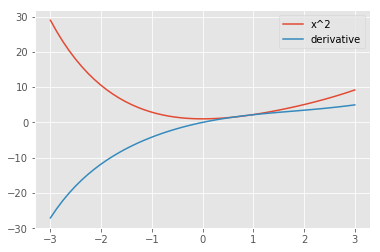

In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

x = np.linspace(-3, 3)
x_squared = list(map(fun, x))
x_squared_der = list(map(grad, x))

plt.plot(x, x_squared, label='x^2')
plt.plot(x, x_squared_der, label='derivative')
plt.legend(loc='best')

# Why that rocks

In [27]:
my_vector = T.vector('float64')

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) + 1. / T.arcsinh(my_scalar)).mean() / (my_scalar**2 + 1) + 0.01 * T.sin(2 * my_scalar**1.5) * (T.sum(my_vector) * my_scalar**2) * T.exp((my_scalar - 4)**2) / (1 + T.exp((my_scalar - 4)**2)) * (1. - (T.exp( - (my_scalar - 4)**2)) / (1 + T.exp( - (my_scalar - 4)**2)))**2

der_by_scalar, der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector)

compute_weird_function = theano.function([my_scalar, my_vector], weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar, my_vector], der_by_scalar)

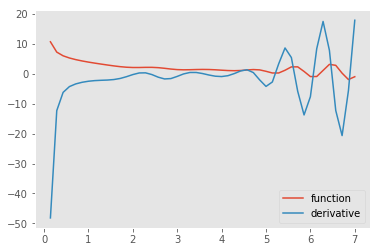

In [28]:
#Plotting your derivative
vector_0 = [1, 2, 3]

scalar_space = np.linspace(0, 7)

y = [compute_weird_function(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y, label='function')
y_der_by_scalar = [compute_der_by_scalar(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend(loc='best')

# Almost done - Updates

* updates are a way of changing shared variables at after function call.

* technically it's a dictionary {shared_variable : a recipe for new value} which is has to be provided when function is compiled

That's how it works:

In [29]:
# Multiply shared vector by a number and save the product back into shared vector

inputs = [input_scalar]
outputs = [scalar_times_shared] #return vector times scalar

my_updates = {
    shared_vector_1:scalar_times_shared #and write this same result bach into shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [30]:
shared_vector_1.set_value(np.arange(5))

#initial shared_vector_1
print('initial shared value:', shared_vector_1.get_value())

# evaluating the function (shared_vector_1 will be changed)
print('compute_and_save(2) returns', compute_and_save(2))

#evaluate new shared_vector_1
print('new shared value:', shared_vector_1.get_value())

('initial shared value:', array([ 0.,  1.,  2.,  3.,  4.]))
('compute_and_save(2) returns', [array([ 0.,  2.,  4.,  6.,  8.])])
('new shared value:', array([ 0.,  2.,  4.,  6.,  8.]))


# Logistic regression example

Implement the regular logistic regression training algorithm

Tips:
* Weights fit in as a shared variable
* X and y are potential inputs
* Compile 2 functions:
 * train_function(X, y) - returns error and computes weights' new values __(through updates)__
 * predict_fun(X) - just computes probabilities ("y") given data
 
 
We shall train on a two-class MNIST dataset
* please note that target y are {0,1} and not {-1,1} as in some formulae

In [31]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X = mnist.data
y = mnist.target
print type(X)
print type(y)

print('y [shape - {}]:{}'.format(str(y.shape), y[:10]))
print('X [shape - {}]:'.format(str(X.shape)))
print(X[:1])
print(y[:1])

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
y [shape - (360,)]:[0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]]
[0]


In [32]:
X = X / 20

In [33]:
X = np.concatenate((np.ones(shape=(X.shape[0], 1)), X), axis=1)

In [34]:
# inputs and shareds
shared_weights = theano.shared(np.random.uniform(size=(np.size(X, axis=1))))
# shared_weights = theano.shared(np.zeros(X.shape[1]))
input_X = T.matrix(dtype='float64')
input_y = T.vector(dtype='float64')

In [35]:
shared_weights.get_value()

array([ 0.39993187,  0.00970062,  0.73294633,  0.62982912,  0.57089239,
        0.59003819,  0.92062629,  0.73102385,  0.85515013,  0.13846885,
        0.82813956,  0.28149618,  0.66743709,  0.70750202,  0.91913983,
        0.45429323,  0.63733909,  0.30992349,  0.45017017,  0.05486058,
        0.11432598,  0.14148775,  0.59685892,  0.8984752 ,  0.05038147,
        0.34114088,  0.08743648,  0.50917403,  0.20674894,  0.77716653,
        0.59504842,  0.10213091,  0.04370977,  0.00373806,  0.3302693 ,
        0.77001193,  0.62861852,  0.76760685,  0.89781863,  0.44452488,
        0.78411327,  0.06567342,  0.30363265,  0.85069023,  0.47205982,
        0.1714024 ,  0.89198317,  0.61443421,  0.24524438,  0.67946029,
        0.88444481,  0.03868519,  0.76071672,  0.23059152,  0.85633584,
        0.3624475 ,  0.78291895,  0.34007942,  0.75832531,  0.21906756,
        0.3134042 ,  0.56897066,  0.65515042,  0.13070426,  0.5387773 ])

In [36]:
predicted_y = T.nnet.sigmoid(input_X.dot(shared_weights))                                                #<predicted probabilities for input_X>
loss = - T.dot(input_y, T.log(predicted_y)) - T.dot((1 - input_y), T.log(1 - predicted_y))    #<logistic loss (scalar, mean over sample)>

grad = T.grad(loss, shared_weights)                  #<gradient of loss over model weights>

updates = [(
    shared_weights, shared_weights - 0.01 * grad      #Implement your favorite stochastic optimization algorithm
)]

In [37]:
# train_function = <compile function that takes X and y, returns log loss and updates weights>
# predict_function = <compile function that takes X and computes probabilities of y>

In [38]:
train_function = theano.function([input_X, input_y], T.log(loss), updates=updates)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [39]:
predict_function = theano.function([input_X], predicted_y)

In [40]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

/home/david/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270, 65), (90, 65), (270,), (90,))

loss at iter 0: 7.06577214827
('train auc:', 0.9981889029142198)
('test auc:', 1.0)
loss at iter 1: 5.08425512583
('train auc:', 0.99912189232204596)
('test auc:', 1.0)
loss at iter 2: 5.80842087235
('train auc:', 1.0)
('test auc:', 1.0)
loss at iter 3: 5.46987225317
('train auc:', 1.0)
('test auc:', 1.0)
loss at iter 4: 3.84290924301
('train auc:', 1.0)
('test auc:', 1.0)
resulting weights:


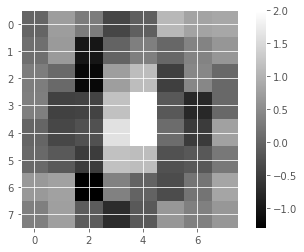

In [42]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train, y_train)
    print('loss at iter {}: {}'.format(i, loss_i))
    print('train auc:', roc_auc_score(y_train,predict_function(X_train)))
    print('test auc:', roc_auc_score(y_test,predict_function(X_test)))
#     print y_test
#     print predict_function(X_test)
    
print('resulting weights:')
          
plt.imshow(shared_weights.get_value()[1:].reshape(8, -1), cmap='gray')
plt.colorbar()

# Report

I did such and such, that did that cool thing and my awesome logistic regression bloated out that stuff. Finally, i did that thing and felt like Einstein. That cool article and that kind of weed helped me so much (if any).

In this assigment We used logistic regression to seperate 0 and 1 numbers. I used theano to complete this task. I have created the matrix for input data, and vector to store the labels, also shared variable to store weights. The shared variable I initializes as random numbers and my regression nothing had learned. Maybe the values were high, so then I tried to initialize weights with 0s. Also I've normalised the input data and added the bias.


























# SPOILERS!

## Recommended pipeline
* Adapt logistic regression to classify some number against others (e.g. zero vs nonzero)
    * Generalize it to multiclass logistic regression.
* Instead of weight vector you'll have to use matrix (feature_id x class_id)
* softmax (exp over sum of exps) can be implemented manually or as T.nnet.softmax (stable)
* probably better to use STOCHASTIC gradient descent (minibatch)
     in which case sample should probably be shuffled (or use random subsamples on each iteration)